## Mini AlexNet Baseline w/Dropout Results

### use Batchnorm and Dropout on all layers

Expects:

- weight.h5 files in ./weights 
- CIFAR10 data in ../data/cifar-10-batches-py/
- Layer 8 becomes Layer 9 here

and while the keras code needs py27, the notebooks can use py3.6 


In [1]:
import sys
import pickle, time
from copy import deepcopy
from shutil import copy
from tqdm import tqdm_notebook as tqdm

import numpy as np
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard, EarlyStopping
from keras.optimizers import SGD
from keras.initializers import Constant
import keras.backend as K

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix

import import_ipynb
import RMT_Util

/Users/charlesmartin14/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/charlesmartin14/.local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


importing notebook from RMT_Util.ipynb
3.6.5 |Anaconda custom (64-bit)| (default, Apr 26 2018, 08:42:37) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
numpy version 1.14.2
scipy version 1.0.1
tensforflow version 1.5.0-dev20171116
keras version 2.1.5
sklearn version 0.19.1
powerlaw version 1.4.3


In [2]:
DATA_DIR = "./data"

BASELINE_outfile = 'results/cifar10_alexnet.out'

BASELINE_final_weightfile = 'weights/alexnet.b16.final.h5'
BASELINE_per_epoch_weightfile = "weights/alexnet.b16.e{}.h5"
NUM_BASELINE_EPOCHS = 100


DROPOUT_outfile = 'results/cifar10_alexnet.dp.out '

DROPOUT_final_weightfile = 'weights/alexnet.dp.b16.final.h5'
DROPOUT_per_epoch_weightfile = "weights/alexnet.dp.b16.e{}.h5"
NUM_DROPOUT_EPOCHS = 100

DROPOUT_ensemble_weightfile = "weights/alexnet.dp.b16.id{}.h5"

DROPOUT_init_weighfile = 'weights/alexnet.dp.b16.e0.h5'

NUM_ENSEMBLE_RUNS = 10
N7, M7 = 4096, 384
N8, M8 = 384, 192

Q7 = float(N7)/float(M7)
Q8 = float(N8)/float(M8)

LAYER_FC1 = 7
LAYER_FC2 = 9

ENTROPY_FILE = "img/mini-alexnet-dropout-entropy-per-epoch.png"
RANK_FILE = "img/mini-alexnet-dropout-rank-per-epoch.png"
ACCURACY_FILE = "img/mini-alexnet-dropout-accuracy-per-epoch.png"


TITLE_FC1 = r"Mini AlexNet w/Dropout FC1: $\rho_{NR}(\lambda)$ "
TITLE_FC2 = r"Mini AlexNet w/Dropout FC2: $\rho_{NR}(\lambda)$ "


TITLE_RAND_FC1 = r"Mini-AlexNet w/Dropout FC1:"+"\n"+r"$\rho_{NR}(\lambda)$ shuffled 100X"
TITLE_RAND_FC2 = r"Mini-AlexNet w/Dropout FC2:"+"\n"+r"$\rho_{NR}(\lambda)$ shuffled 100X"

XLABEL_FC1 = r"Eigenvalues $\lambda$ of $\mathbf{X}=\mathbf{W}_{FC1}^{T}\mathbf{W}_{FC1}$"
XLABEL_FC2 = r"Eigenvalues $\lambda$ of $\mathbf{X}=\mathbf{W}_{FC2}^{T}\mathbf{W}_{FC2}$"

XLABEL = r"Eigenvalues $\lambda$ of $\mathbf{X}=\mathbf{W}}^{T}\mathbf{W}$"
YLABEL = r"$\rho_{NR}(\lambda)$ shuffled $100X$"

FC1_FILENAME_1 = "img/mini-alexnet-dropout-fc1-9spikes.png"
FC2_FILENAME_1 = "img/mini-alexnet-dropout-fc2-9spikes.png"

FC1_FILENAME_2 = "img/mini-alexnet-dropout-fc1-10spikes.png"
FC2_FILENAME_2 = "img/mini-alexnet-dropout-fc2-10spikes.png"

RAND_FC1_FILENAME = "img/mini-alexnet-dropout-fc1-rand.png"
RAND_FC2_FILENAME = "img/mini-alexnet-dropout-fc2-rand.png"


In [3]:
matplotlib.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = [5,5]

### Form symbolic Links to results

In [4]:
!ln -s /Users/charlesmartin14/work/DLGeneralization/data .
!rm results; ln -s /Users/charlesmartin14/work/DLGeneralization/Mini*Alex*/results .
!rm weights; ln -s /Users/charlesmartin14/work/DLGeneralization/Mini*Alex*/weights .

ln: ./data: File exists


In [5]:
!cd weights; ln -s alexnet.dp.b16.final.h5 alexnet.dp.b16.e100.h5
!cd weights; ls -l alexnet.dp.b16.e100.h5

ln: alexnet.dp.b16.e100.h5: File exists
lrwxr-xr-x  1 charlesmartin14  staff  23 Apr 11 11:25 alexnet.dp.b16.e100.h5 -> alexnet.dp.b16.final.h5


In [6]:
!ls weights/*dp* | head

weights/alexnet.dp.b16.e0.h5
weights/alexnet.dp.b16.e1.h5
weights/alexnet.dp.b16.e10.h5
weights/alexnet.dp.b16.e100.h5
weights/alexnet.dp.b16.e11.h5
weights/alexnet.dp.b16.e12.h5
weights/alexnet.dp.b16.e13.h5
weights/alexnet.dp.b16.e14.h5
weights/alexnet.dp.b16.e15.h5
weights/alexnet.dp.b16.e16.h5


## Baseline (first, for comparison)

In [7]:
model = RMT_Util.Alexnet_Model(batchnorm=False)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

## Entropy and Accuracies per Epoch

In [8]:
fc1_bsln_entropies, fc2_bsln_entropies = [], []
fc1_bsln_ranks, fc2_bsln_ranks = [], []

for epoch in tqdm(range(NUM_BASELINE_EPOCHS)):
    model.load_weights(BASELINE_per_epoch_weightfile.format(epoch))   
    fc1_bsln_entropies.append(RMT_Util.layer_entropy(model,LAYER_FC1))
    fc2_bsln_entropies.append(RMT_Util.layer_entropy(model,LAYER_FC2-1)) # note
    
    fc1_bsln_ranks.append(RMT_Util.layer_soft_rank(model,LAYER_FC1))
    fc2_bsln_ranks.append(RMT_Util.layer_soft_rank(model,LAYER_FC2-1)) # note

In [9]:
assert(len(fc1_bsln_entropies)==NUM_BASELINE_EPOCHS)
assert(len(fc2_bsln_entropies)==NUM_BASELINE_EPOCHS)

assert(len(fc1_bsln_ranks)==NUM_BASELINE_EPOCHS)
assert(len(fc2_bsln_ranks)==NUM_BASELINE_EPOCHS)

## Baseline  w/Dropout 

### (Batchnorm on FC1 and FC2)

In [10]:
model = RMT_Util.Alexnet_Model(batchnorm=True)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [11]:
fc1_entropies, fc2_entropies = [], []
fc1_ranks, fc2_ranks = [], []

for epoch in tqdm(range(NUM_DROPOUT_EPOCHS)):
    model.load_weights(DROPOUT_per_epoch_weightfile.format(epoch))   
    fc1_entropies.append(RMT_Util.layer_entropy(model, LAYER_FC1))
    fc2_entropies.append(RMT_Util.layer_entropy(model, LAYER_FC2))
    
    fc1_ranks.append(RMT_Util.layer_soft_rank(model, LAYER_FC1))
    fc2_ranks.append(RMT_Util.layer_soft_rank(model, LAYER_FC2))

In [12]:
assert(len(fc1_entropies)==NUM_DROPOUT_EPOCHS)
assert(len(fc2_entropies)==NUM_DROPOUT_EPOCHS)

assert(len(fc1_ranks)==NUM_DROPOUT_EPOCHS)
assert(len(fc2_ranks)==NUM_DROPOUT_EPOCHS)

saved file img/mini-alexnet-dropout-entropy-per-epoch.png


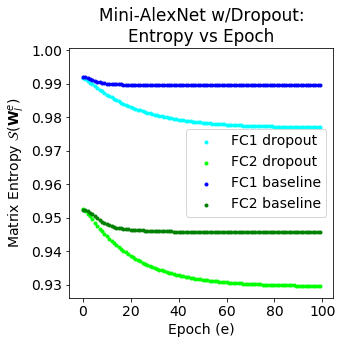

In [13]:
plt.scatter(range(0,len(fc1_entropies)), fc1_entropies, marker='.', color='cyan', label="FC1 dropout")
plt.scatter(range(0,len(fc2_entropies)), fc2_entropies, marker='.', color='lime', label="FC2 dropout")
plt.scatter(range(0,len(fc1_bsln_entropies)), fc1_bsln_entropies, marker='.', color='blue', label="FC1 baseline")
plt.scatter(range(0,len(fc2_bsln_entropies)), fc2_bsln_entropies, marker='.', color='green', label="FC2 baseline")

#lt.ylim([0.905,0.920])
plt.title('Mini-AlexNet w/Dropout:'+'\n'+'Entropy vs Epoch')
plt.xlabel("Epoch (e)")
plt.ylabel(r"Matrix Entropy $\mathcal{S}(\mathbf{W}^{e}_{l})$")
plt.legend()
plt.tight_layout()

plt.savefig(ENTROPY_FILE)
print("saved file {}".format(ENTROPY_FILE))

saved file img/mini-alexnet-dropout-rank-per-epoch.png


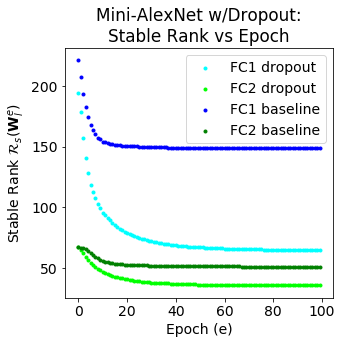

In [14]:
plt.scatter(range(0,len(fc1_ranks)), fc1_ranks, marker='.', color='cyan', label="FC1 dropout")
plt.scatter(range(0,len(fc2_ranks)), fc2_ranks, marker='.', color='lime', label="FC2 dropout")
plt.scatter(range(0,len(fc1_ranks)), fc1_bsln_ranks, marker='.', color='blue', label="FC1 baseline")
plt.scatter(range(0,len(fc2_ranks)), fc2_bsln_ranks, marker='.', color='green', label="FC2 baseline")

#lt.ylim([0.905,0.920])
plt.title('Mini-AlexNet w/Dropout:'+'\n'+'Stable Rank vs Epoch')
plt.xlabel("Epoch (e)")
plt.ylabel(r"Stable Rank $\mathcal{R}_{s}(\mathbf{W}^{e}_{l})$")
plt.legend()
plt.tight_layout()

plt.savefig(RANK_FILE)
print("saved file {}".format(RANK_FILE))

#### Read Dropout Training accuracies from output file

Notice: there is no epoch=0 training accuracy

In [15]:
dp_train_accs = RMT_Util.read_training_accuracies(DROPOUT_outfile)
assert(len(dp_train_accs)==NUM_DROPOUT_EPOCHS)

#### Recompute Baseline Test accuracies 

In [16]:
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='mse', optimizer=opt, metrics=['accuracy'])

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [17]:
test_images, test_labels = RMT_Util.read_test_images(datadir=DATA_DIR)

Loading test images...


In [18]:
dp_test_accs = []
for epoch in tqdm(range(NUM_DROPOUT_EPOCHS)):
    modelfile = DROPOUT_per_epoch_weightfile.format(epoch)
    model.load_weights(modelfile)
    acc =  model.evaluate(test_images, test_labels, batch_size=256)
    dp_test_accs.append(acc[1])

10000/10000 [==============================] - 31s 3ms/step



### Training and test Accuracies vs Epoch

## NO Overtraining w/Dropout

In [19]:
len(dp_train_accs), len(dp_test_accs)

(100, 100)

saved file img/mini-alexnet-dropout-accuracy-per-epoch.png


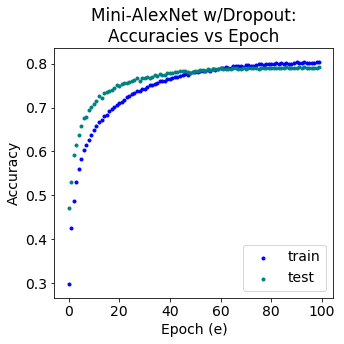

In [20]:
x = range(NUM_DROPOUT_EPOCHS)

plt.scatter(x, dp_train_accs,  marker='.',color='blue', label="train")
plt.scatter(x, dp_test_accs,  marker='.',color='teal', label="test")

plt.title('Mini-AlexNet w/Dropout:'+'\n'+'Accuracies vs Epoch')
plt.xlabel("Epoch (e)")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()

plt.savefig(ACCURACY_FILE)
print("saved file {}".format(ACCURACY_FILE))

### Fit Marchenko Pastur to ESD

Layer 7 and 8(9): both have a very close outlier (finite size or bleeding out ?) just near the MP edge.  This makes it hard to fit $\sigma_{emp}^{2}$, so we compare to the ESD of shuffled X and make sure the estimate is smaller
$$\sigma_{emp}^{2}<\sigma_{shuf}^{2}$$ 

###  ESD of Shuffled X

In [21]:
Q = Q7
model.load_weights(DROPOUT_final_weightfile)
W7 = model.layers[LAYER_FC1].get_weights()[0]
W7.shape
evals = RMT_Util.get_shuffled_eigenvalues(W7, layer=LAYER_FC1)
evals = (np.array(evals).flatten())

get_shuffled_eigenvalues



% spikes outside bulk 0.00
% sigma 1.2516
1.251580053391286
1.251580053391286


RMT_Util.ipynb:7: RuntimeWarning: divide by zero encountered in true_divide
  "## RMT Util\n",
RMT_Util.ipynb:7: RuntimeWarning: invalid value encountered in sqrt
  "## RMT Util\n",


saved figure img/mini-alexnet-dropout-fc1-rand.png


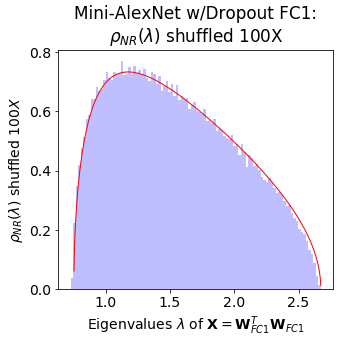

In [22]:
sigma = RMT_Util.plot_ESD_and_fit(model=None, eigenvalues=evals, Q=Q)
print(sigma)

print(sigma)
plt.title(TITLE_RAND_FC1)
plt.xlabel(XLABEL_FC1)
plt.ylabel(YLABEL)
plt.tight_layout()

filename=RAND_FC1_FILENAME
plt.savefig(filename)
print("saved figure {}".format(filename))

### Various MP Fits

Use in paper ?  Only if really interesting

RMT_Util.ipynb:7: RuntimeWarning: divide by zero encountered in true_divide
  "## RMT Util\n",
RMT_Util.ipynb:7: RuntimeWarning: invalid value encountered in sqrt
  "## RMT Util\n",


% spikes outside bulk 2.40
% sigma 1.2464
1.2464230527272697
saved figure img/mini-alexnet-dropout-fc1-9spikes.png


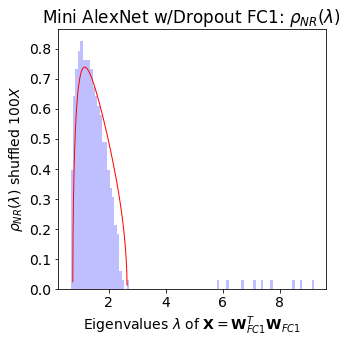

In [23]:
Q = Q7
sigma = RMT_Util.plot_ESD_and_fit(model=model, weightfile=DROPOUT_final_weightfile, layer=LAYER_FC1, 
                            Q=Q, num_spikes=9, sigma=None, color='blue')

print(sigma)
plt.title(TITLE_FC1)
plt.xlabel(XLABEL_FC1)
plt.ylabel(YLABEL)
plt.tight_layout()

filename=FC1_FILENAME_1
plt.savefig(filename)
print("saved figure {}".format(filename))

RMT_Util.ipynb:7: RuntimeWarning: divide by zero encountered in true_divide
  "## RMT Util\n",
RMT_Util.ipynb:7: RuntimeWarning: invalid value encountered in sqrt
  "## RMT Util\n",


% spikes outside bulk 2.67
% sigma 1.2173
1.2464230527272697
saved figure img/mini-alexnet-dropout-fc1-10spikes.png


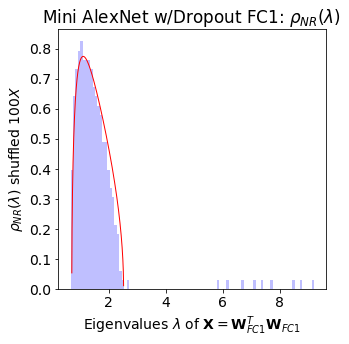

In [24]:
Q = Q7
RMT_Util.plot_ESD_and_fit(model=model, weightfile=DROPOUT_final_weightfile, layer=LAYER_FC1, 
                            Q=Q, num_spikes=10, sigma=None, color='blue')

print(sigma)
plt.title(TITLE_FC1)
plt.xlabel(XLABEL_FC1)
plt.ylabel(YLABEL)
plt.tight_layout()

filename=FC1_FILENAME_2
plt.savefig(filename)
print("saved figure {}".format(filename))

In [25]:
Q = Q8
model.load_weights(DROPOUT_final_weightfile)
W8 = model.layers[LAYER_FC2].get_weights()[0]
W8.shape
evals = RMT_Util.get_shuffled_eigenvalues(W8, layer=LAYER_FC2)
evals = (np.array(evals).flatten())

get_shuffled_eigenvalues



% spikes outside bulk 0.00
% sigma 1.0426
1.0425634519538391
1.0425634519538391


RMT_Util.ipynb:7: RuntimeWarning: divide by zero encountered in true_divide
  "## RMT Util\n",
RMT_Util.ipynb:7: RuntimeWarning: invalid value encountered in sqrt
  "## RMT Util\n",


saved figure img/mini-alexnet-dropout-fc2-rand.png


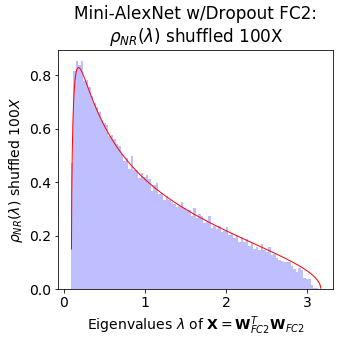

In [26]:
sigma = RMT_Util.plot_ESD_and_fit(model=None, eigenvalues=evals, Q=Q)
print(sigma)

print(sigma)
plt.title(TITLE_RAND_FC2)
plt.xlabel(XLABEL_FC2)
plt.ylabel(YLABEL)
plt.tight_layout()

filename=RAND_FC2_FILENAME
plt.savefig(filename)
print("saved figure {}".format(filename))

RMT_Util.ipynb:7: RuntimeWarning: divide by zero encountered in true_divide
  "## RMT Util\n",
RMT_Util.ipynb:7: RuntimeWarning: invalid value encountered in sqrt
  "## RMT Util\n",


% spikes outside bulk 4.92
% sigma 0.9081
1.0425634519538391
saved figure img/mini-alexnet-dropout-fc2-9spikes.png


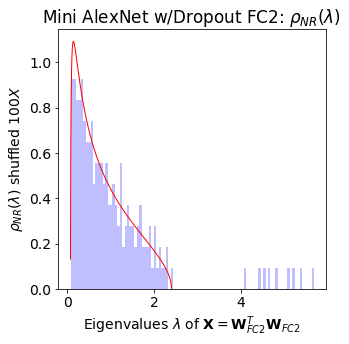

In [27]:
Q = Q8
RMT_Util.plot_ESD_and_fit(model = model, weightfile = DROPOUT_final_weightfile, 
                          layer=LAYER_FC2, Q=Q, num_spikes=9, sigma=None, color='blue')

print(sigma)
plt.title(TITLE_FC2)
plt.xlabel(XLABEL_FC2)
plt.ylabel(YLABEL)
plt.tight_layout()

filename=FC2_FILENAME_1
plt.savefig(filename)
print("saved figure {}".format(filename))

RMT_Util.ipynb:7: RuntimeWarning: divide by zero encountered in true_divide
  "## RMT Util\n",
RMT_Util.ipynb:7: RuntimeWarning: invalid value encountered in sqrt
  "## RMT Util\n",


% spikes outside bulk 5.49
% sigma 0.8925
1.0425634519538391
saved figure img/mini-alexnet-dropout-fc2-10spikes.png


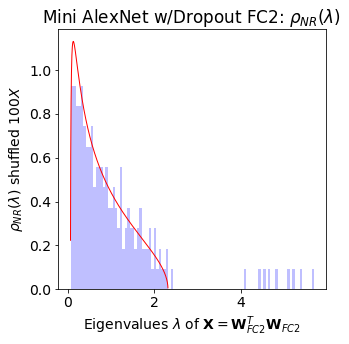

In [28]:
Q = Q8
RMT_Util.plot_ESD_and_fit(model = model, weightfile = DROPOUT_final_weightfile, 
                          layer=LAYER_FC2, Q=Q, num_spikes=10, sigma=None, color='blue')

print(sigma)
plt.title(TITLE_FC2)
plt.xlabel(XLABEL_FC2)
plt.ylabel(YLABEL)
plt.tight_layout()

filename=FC2_FILENAME_2
plt.savefig(filename)
print("saved figure {}".format(filename))

## Scree Plots:  

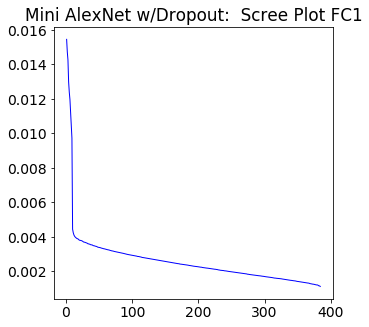

In [29]:
RMT_Util.scree_plot(model, DROPOUT_final_weightfile, layer=LAYER_FC1, label="FC1")
plt.title("Mini AlexNet w/Dropout:  Scree Plot FC1")
plt.show()


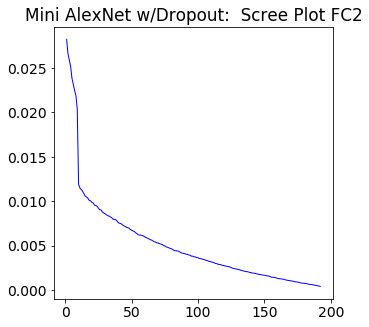

In [30]:
RMT_Util.scree_plot(model, DROPOUT_final_weightfile, layer=LAYER_FC2, label="FC2")
plt.title("Mini AlexNet w/Dropout:  Scree Plot FC2")
plt.show()